In [11]:
%pip install pandas --quiet
%pip install xgboost scikit-learn matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [13]:
# Read in the complete data
complete_data_df = pd.read_csv('../../data/processed/complete_data.csv')

In [15]:
# Use features that are available in our split dataset
# We need to work with the complete_data_df instead of the limited selected_data_with_date
print("\nAll available columns in complete_data_df:")
print(complete_data_df.columns.tolist())

# Re-create train/test split with all features
complete_data_df['datetime_au'] = pd.to_datetime(complete_data_df['datetime_au'])
complete_data_df['year'] = complete_data_df['datetime_au'].dt.year

# Split data into training (2016-2018) and testing (2019) with all features
train_data_full = complete_data_df[complete_data_df['year'].isin([2016, 2017, 2018])].copy()
test_data_full = complete_data_df[complete_data_df['year'] == 2019].copy()

# Enhanced feature selection using all available features
feature_columns = [
    'is_weekend', 'is_weekday', 'avg_temp', 'min_temp', 'max_temp',
    'is_summer', 'is_autumn', 'is_winter', 'is_spring',
    'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_sunday',
    'precipitation', 'sunlight', 'hd_next_24h', 'cd_next_24h',
    'is_jan', 'is_feb', 'is_mar', 'is_apr', 'is_may', 'is_jun',
    'is_jul', 'is_aug', 'is_sep', 'is_oct', 'is_nov', 'is_dec'
]

target_column = 'sum_30_min_demand'

# Prepare training data (2016-2018)
X_train = train_data_full[feature_columns].copy()
y_train = train_data_full[target_column].copy()

# Prepare test data (2019)
X_test = test_data_full[feature_columns].copy()
y_test = test_data_full[target_column].copy()

print(f"\nFinal data shapes:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nTarget variable statistics:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Test - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")


All available columns in complete_data_df:
['datetime_au', 'is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday', 'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar', 'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct', 'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand', 'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight']

Final data shapes:
X_train shape: (1096, 32)
y_train shape: (1096,)
X_test shape: (365, 32)
y_test shape: (365,)

Target variable statistics:
Train - Mean: 384440.72, Std: 35626.94
Test - Mean: 382231.72, Std: 37487.02


In [46]:
# Model 1: Original data (no normalization)
print("1. Training XGBoost on original data...")
xgb_original = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_original.fit(X_train, y_train)
y_train_pred_orig = xgb_original.predict(X_train)
y_test_pred_orig = xgb_original.predict(X_test)

1. Training XGBoost on original data...


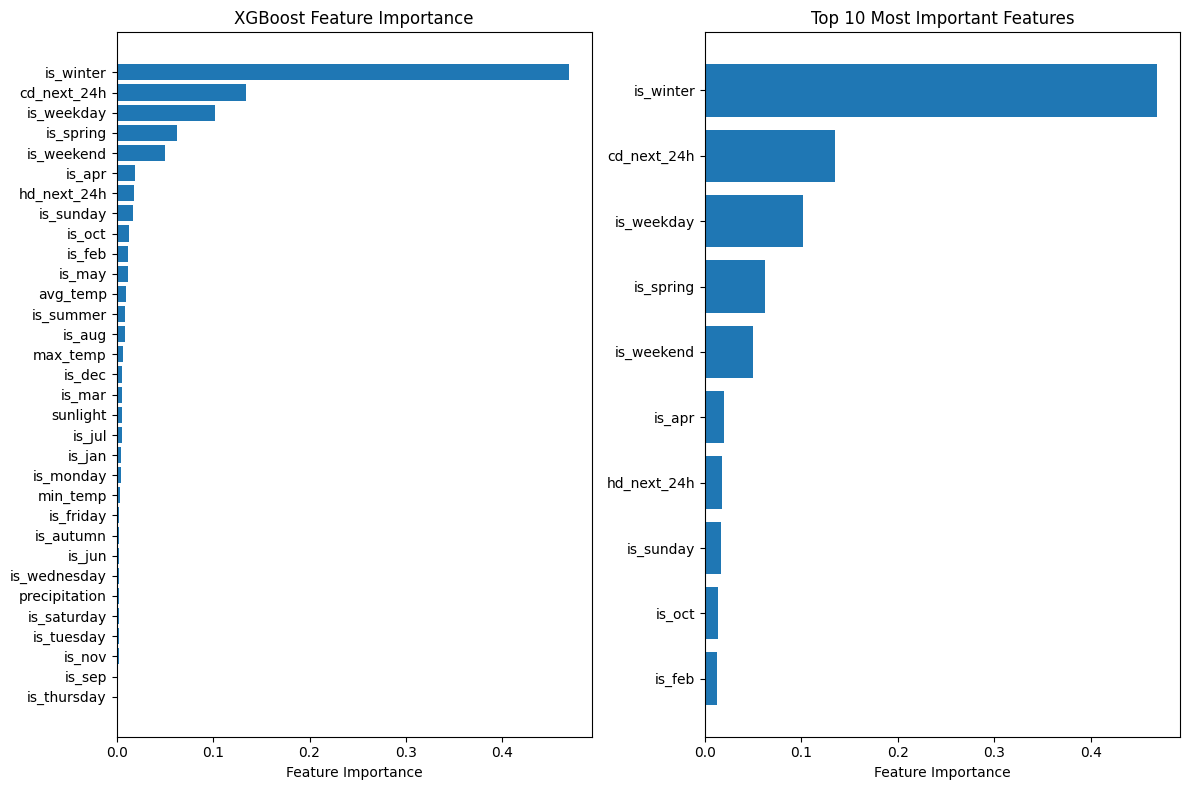

Top 10 Most Important Features:
 1. is_winter           : 0.4690
 2. cd_next_24h         : 0.1343
 3. is_weekday          : 0.1015
 4. is_spring           : 0.0624
 5. is_weekend          : 0.0501
 6. is_apr              : 0.0193
 7. hd_next_24h         : 0.0178
 8. is_sunday           : 0.0169
 9. is_oct              : 0.0130
10. is_feb              : 0.0121


In [22]:
# Feature Importance Analysis
feature_importance = xgb_original.feature_importances_
feature_names = X_train.columns

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()

# Plot top 10 features
plt.subplot(1, 2, 2)
top_10 = importance_df.head(10)
plt.barh(range(len(top_10)), top_10['importance'])
plt.yticks(range(len(top_10)), top_10['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
for i, (feature, importance) in enumerate(importance_df.head(10).values, 1):
    print(f"{i:2d}. {feature:20s}: {importance:.4f}")

In [47]:
def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and display model evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {'RMSE': rmse, 'MAE': mae, 'R²': r2, 'MAPE': mape}

In [48]:
# Hyperparameter tuning (optional - can be time consuming)
print("Starting hyperparameter tuning...")
print("Note: This may take several minutes...")

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 4, 6, 8, 10],
    'learning_rate': [0.02, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

# Use TimeSeriesSplit for cross-validation (appropriate for time series data)
tscv = TimeSeriesSplit(n_splits=3)

# Create XGBoost regressor for tuning
xgb_tuning = xgb.XGBRegressor(random_state=42, n_jobs=-1)

# Create custom MAPE scorer for GridSearchCV
from sklearn.metrics import make_scorer

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE - avoiding division by zero"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Create scorer (note: we want to minimize MAPE, so we use greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Perform grid search (using a smaller subset for faster execution)
grid_search = GridSearchCV(
    xgb_tuning, 
    param_grid, 
    cv=tscv, 
    scoring=mape_scorer,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {-grid_search.best_score_:.2f}")

# Train final model with best parameters
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Make predictions with tuned model
y_train_pred_tuned = best_xgb_model.predict(X_train)
y_test_pred_tuned = best_xgb_model.predict(X_test)

# Evaluate tuned model
train_metrics_tuned = evaluate_model(y_train, y_train_pred_tuned, "Training (Tuned)")
test_metrics_tuned = evaluate_model(y_test, y_test_pred_tuned, "Test (Tuned)")

Starting hyperparameter tuning...
Note: This may take several minutes...
Fitting 3 folds for each of 1600 candidates, totalling 4800 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.6}
Best cross-validation score: 2.96


MODEL PERFORMANCE COMPARISON
  Metric  Basic XGBoost (Test)  Tuned XGBoost (Test)
    RMSE          14873.418640          15047.610227
     MAE          10251.914862          10363.423934
      R²              0.842148              0.838429
MAPE (%)              2.684718              2.724119


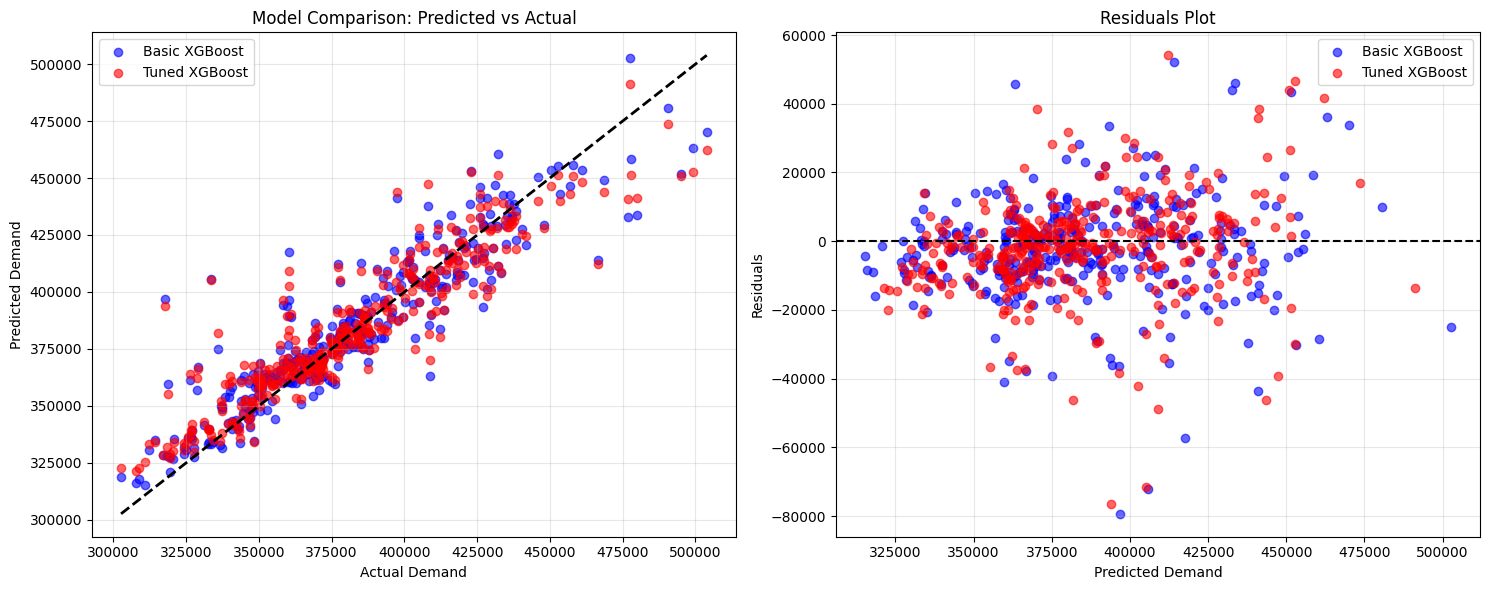


DEMAND FORECASTING SUMMARY
• Dataset: 1096 training samples, 365 test samples
• Features: 32 features
• Best Model: Basic XGBoost
• Final Test R²: 0.8421
• Final Test RMSE: 14873.42
• Final Test MAPE: 2.68


In [49]:
# Model Comparison Summary
print("="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

# Evaluate original model on test set
test_metrics_orig = evaluate_model(y_test, y_test_pred_orig, "Test (Original)")

comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'R²', 'MAPE (%)'],
    'Basic XGBoost (Test)': [
        test_metrics_orig['RMSE'], 
        test_metrics_orig['MAE'], 
        test_metrics_orig['R²'], 
        test_metrics_orig['MAPE']
    ],
    'Tuned XGBoost (Test)': [
        test_metrics_tuned['RMSE'], 
        test_metrics_tuned['MAE'], 
        test_metrics_tuned['R²'], 
        test_metrics_tuned['MAPE']
    ]
})

print(comparison_df.to_string(index=False))

# Final predictions visualization
plt.figure(figsize=(15, 6))

# Plot final comparison
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred_orig, alpha=0.6, label='Basic XGBoost', color='blue')
plt.scatter(y_test, y_test_pred_tuned, alpha=0.6, label='Tuned XGBoost', color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Model Comparison: Predicted vs Actual')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot residuals
plt.subplot(1, 2, 2)
residuals_basic = y_test - y_test_pred_orig
residuals_tuned = y_test - y_test_pred_tuned
plt.scatter(y_test_pred_orig, residuals_basic, alpha=0.6, label='Basic XGBoost', color='blue')
plt.scatter(y_test_pred_tuned, residuals_tuned, alpha=0.6, label='Tuned XGBoost', color='red')
plt.axhline(y=0, color='k', linestyle='--')
plt.xlabel('Predicted Demand')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("DEMAND FORECASTING SUMMARY")
print("="*60)
print(f"• Dataset: {X_train.shape[0]} training samples, {X_test.shape[0]} test samples")
print(f"• Features: {len(feature_columns)} features")
print(f"• Best Model: {'Tuned XGBoost' if test_metrics_tuned['R²'] > test_metrics_orig['R²'] else 'Basic XGBoost'}")
print(f"• Final Test R²: {max(test_metrics_orig['R²'], test_metrics_tuned['R²']):.4f}")
print(f"• Final Test RMSE: {min(test_metrics_orig['RMSE'], test_metrics_tuned['RMSE']):.2f}")
print(f"• Final Test MAPE: {min(test_metrics_orig['MAPE'], test_metrics_tuned['MAPE']):.2f}")
print("="*60)